In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline
from ipywidgets import interact, interact_manual
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("numbers-on-unemployment-benefits.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 2 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Month                                                                       440 non-null    object 
 1   Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992  439 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


Отрезаем мусор в конце данных

In [5]:
df = df[:-1]

In [6]:
series = df['Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992']

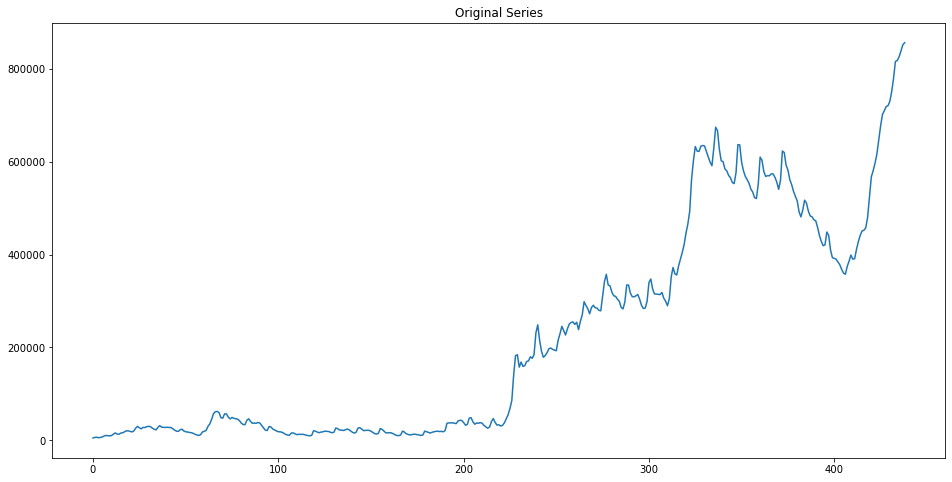

In [7]:
plt.figure(figsize=(16, 8))
plt.title('Original Series')
plt.plot(series)
plt.show()

1. Используем простое матожидание

In [8]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [9]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(16,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

In [10]:
@interact
def simulate_mean_detector(threshold=(0, 7, 0.05)):
    simulate(MeanDetector(threshold=threshold), series)

interactive(children=(FloatSlider(value=3.0, description='threshold', max=7.0, step=0.05), Output()), _dom_cla…

2. Пробуем потоковые окна

In [11]:

class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

In [12]:
@interact
def simulate_zscore_detector(window_size=(2, 100, 1), threshold=(0, 20, 0.1)):
    simulate(ZScoreDetector(window_size=window_size, threshold=threshold), series)

interactive(children=(IntSlider(value=51, description='window_size', min=2), FloatSlider(value=10.0, descripti…

Две степени свободы позволяют более тонко выбрать возмущения, на которые будет реагировать детектор - подбором параметров можно попасть практически в любую точку графика.

OneClass SVM

In [14]:
series_rs = series.values.reshape(-1, 1)

In [15]:
@interact
def simulate_one_class_svm(train_len=(50, 400, 10), nu=(0.01, 1, 0.01), gamma10pow=(-15, 3, 1)):
    series_len = len(series)
    clf = OneClassSVM(nu=nu, kernel="rbf", gamma=10**gamma10pow)
    clf.fit(series_rs[:train_len])

    y_pred_train = clf.predict(series_rs[:train_len])
    y_pred_test = clf.predict(series_rs[train_len:])
    
    y = np.linspace(30, 70, 500).reshape(-1, 1)
    Z = clf.decision_function(y).reshape(-1,1)
    Z = np.hstack((Z, Z))
    y = y.reshape(500)
    
    false_positive_train = []
    false_positive_test = []
    for i, t in enumerate(y_pred_train):
        if t != 1:
            false_positive_train.append((i, series_rs[i]))

    for i, t in enumerate(y_pred_test):
        if t != 1:
            idx = len(y_pred_train) + i
            false_positive_test.append((idx, series_rs[idx]))

    false_positive_train = np.array(false_positive_train)
    false_positive_test = np.array(false_positive_test)

    plt.figure(figsize=(16,8))
    plt.plot(range(train_len), series_rs[:train_len], 'ro', linewidth=5)
    plt.plot(range(train_len), series_rs[:train_len], 'r-', linewidth=1)
    plt.plot(range(train_len, series_len), series_rs[train_len:], 'bo', linewidth=5)
    plt.plot(range(train_len - 1, series_len), series_rs[train_len - 1:], 'b-', linewidth=1)
    plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
    plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
    plt.show()

interactive(children=(IntSlider(value=220, description='train_len', max=400, min=50, step=10), FloatSlider(val…

Данный метод сложен в настройке и требует хорошего понимания математики, которая за ним лежит.

IsolationForest

In [16]:
@interact
def simulate_isolation_forest(outliers=(0, 0.5, 0.01)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series)
    model = IsolationForest(contamination=outliers)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

interactive(children=(FloatSlider(value=0.25, description='outliers', max=0.5, step=0.01), Output()), _dom_cla…

На мой взгляд, для подобых графиков данный метод подходит не очень, а вот для отстрела выбросов мог бы пригодиться.